## Marketing Dataset for Portuguese Bank Telemarketing Campaign

#### Feature of Interest:  
'y' is the response variable, the target variable. The variable is binary, consisting of either yes or no, where yes means client purchased a subscription, and no means client did not convert the subscription. This variable on the aggregate can be considered a conversion rate.  

#### Project objective:  
1) Identify key features which likely contribute to marketing success.   
2) Build a classification model quanitfying ability to predict the conversion rate for a similar marketing campaign in the future.     

#### High level process:    
1) Test three feature selection algorithms and one dimension reduction algorithm.  
2) Test four statistical learning / modeling algorithms.    

#### Practical application:   
Gain insights into customer profile and effectiveness of telephone based marketing approach.  

### Data Set Information:  

The data is related to the direct telemarketing campaigns of a Portuguese bank. Telephone calls, often multiple calls were made to determine if the outcome (bank term deposit) would be subscribed (yes or no).

Dataset found on UCI site:
https://archive.ics.uci.edu/ml/datasets/Bank%2BMarketing

This analysis used the bank-additional-full.csv with 41188 results with 20 attributes ordered by date, May 2008 to November 2010. 


## Citation
Similar data originally analyzed by team:  
[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

### Input variables
#### Client attributes
1 - age (numeric)  
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')  
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)  
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')  
5 - default: has credit in default? (categorical: 'no','yes','unknown')  
6 - housing: has housing loan? (categorical: 'no','yes','unknown')  
7 - loan: has personal loan? (categorical: 'no','yes','unknown')  
#### Last contact of the current campaign attributes
8 - contact: contact communication type (categorical: 'cellular','telephone')  
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')  
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')  
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.  
#### Other campaign attributes  
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)  
14 - previous: number of contacts performed before this campaign and for this client (numeric)  
15 - poutcome: outcome of the previous marketing campaign (categorical:   'failure','nonexistent','success')   
#### Social and economic context attributes    
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)    
17 - cons.price.idx: consumer price index - monthly indicator (numeric)  
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)  
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)  
20 - nr.employed: number of employees - quarterly indicator (numeric)  
 

### Target Variable

21 - y: Term deposit subsciption (categorical: 'yes','no')

## Overview:

The motivation behind this project is to use multiple classification algorithms with multiple  feature selection techniques and one dimension reduction technique. Objective is to generate a high reliable classification as measured with the Weighted F1 score. F1 chosen due to an imbalanced target.  

The three feature selection techniques chosen are SelectKBest(SKB), Recursive Feature Elimination(RFE), and ExtraTreesClassifier(ETC). Principle Component Analysis(PCA) will be used for dimension reduction.

The four models chosen are Logistic Regression(LR), Random Forest(RF), Support Vector Machine(SVM), and Gradient Boost Classifier (GBC). 

LR will be used in feature selection as it is relatively easy to apply and sensitive to bad inputs, thus lending itself well to that process. 

Process details:  
* Continuous data will be standardized.  
* SMOTE will be used to balance the training set through minority oversampling (no approx 89%.  
* Cross validation used with Pipeline used to minimize overfitting and increase generalization.  
* Four sets of features will be tested with the four models. 
* GridSearchCV will be used to tune hyperparameters. 
* Weighted F1 and the standard deviation of cross validation tests will be used as the performance metric.

Weaknesses: 
* Ultimately PCA is not appropriate for a bank, as audit restrictions and risk governance require transparency. PCA will be included for the sake of comparison.   
* Some models are low bias/high variance, while LR is high bias/low variance.  
* Other weaknesses will be described in the conclusion at the end.

## Problem statement  
Build a classification model quanitfying conversion rate for a similar marketing campaign in the future.       

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rc("font", size=14) # lINE WIDTH, COLOR, FONT
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
from sklearn import preprocessing, ensemble
from sklearn.preprocessing import StandardScaler, PowerTransformer # Yeo-Johnson or Boxcox

# FEATURE SELECTION
from sklearn.feature_selection import SelectKBest, RFE, f_classif, chi2
from sklearn.decomposition import PCA

# FEATURE IMPORTANCE
from xgboost import plot_importance, plot_tree
import statsmodels.api as sm # p-value REPORT

# MODEL SELECTION
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

# MODELS
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier

# PIPELINE
from sklearn.pipeline import Pipeline

# METRICS AND REPORTING
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error

# MINORITY OVERSAMPLING
from imblearn.over_sampling import SMOTE

# TIME BENCHMARKING
import time

## 1. Load The Dataset

In [3]:
# LOAD FILE FROM CSV
# DROP NULLS
df = pd.read_csv(("C:/Users/DJ/Documents/AnacondaPython/Thinkful/FilesToLoad/bank-additional/bank-additional/bank_additional_full.csv")).dropna()

## 2. Exploratory Data Analysis (EDA)

### 2.A EDA - Initial Inspection

In [4]:
# REMOVE LEADING AND TRAILING SPACES, CONVERT TO LOWERCASE, 
# REPLACE SPACE WITH HYPHEN, REPLACE SLASH WITH UNDERSCORE
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('.','_').str.replace('-','_').str.replace('/','_').str.replace('__','_')

In [5]:
# (ROWS, COLUMNS)
df.shape

(41188, 21)

In [6]:
# CHECK IF INT, FLOAT, STR, OBJ LOOK CORRECT
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp_var_rate      41188 non-null float64
cons_price_idx    41188 non-null float64
cons_conf_idx     41188 non-null float64
euribor3m         41188 non-null float64
nr_employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

In [7]:
# VIEW SAMPLE OF DATA RECORDS 
df.iloc[:,0:11].head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307


In [8]:
df.iloc[:,11:21].head()

,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [9]:
# (include='all') FOR ALL, (include='O') FOR STRING, () FOR NUMERIC
df.describe(include='O')

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


In [10]:
df.describe()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


### 2.B EDA - Data Cleaning and Pre-Processing

#### Check for duplicates and remove

In [11]:
# DUPLICATE COUNTS (ROWS, COLUMNS)
df[df.duplicated()].shape

(12, 21)

In [12]:
# VIEW DUPLICATES
df[df.duplicated(keep=False)==True].head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
1265,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
12260,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
14155,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no


In [13]:
# DROP DUPLICATES
df.drop_duplicates(keep=False, inplace=True)
df[df.duplicated()].shape

(0, 21)

#### Check correlation between variable. 

In [14]:
corr=df[['emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']].corr()
corr.style.background_gradient(cmap = 'coolwarm')

,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
emp_var_rate,1,0.775253,0.196473,0.972243,0.906929
cons_price_idx,0.775253,1,0.0593542,0.688129,0.521856
cons_conf_idx,0.196473,0.0593542,1,0.278042,0.100844
euribor3m,0.972243,0.688129,0.278042,1,0.945137
nr_employed,0.906929,0.521856,0.100844,0.945137,1


#### Analysis
'emp_var_rate', 'cons_price_idx', 'euribor3m', 'nr_employed' have high collinearity, high correlations.  
'emp_var_rate' appears to have the highest cross correlation with other variables.   
cons_conf_idx has low correlation with other variables  

#### Conclusion
Keep: cons_price_idx, cons_conf_idx, nr_employed  
Drop: emp_var_rate, euribor3m  

#### Look at features

In [15]:
df.loan.value_counts()

no         33926
yes         6248
unknown      990
Name: loan, dtype: int64

In [16]:
df.default.value_counts()

no         32566
unknown     8595
yes            3
Name: default, dtype: int64

In [17]:
df.housing.value_counts()

yes        21566
no         18608
unknown      990
Name: housing, dtype: int64

In [18]:
df.marital.value_counts()

married     24914
single      11560
divorced     4610
unknown        80
Name: marital, dtype: int64

#### Analysis  
Many features will be dropped for quality of analyis. 
* duration is ex post facto.
* variables with high correlation.
* variables that speak to prior campaigns which may not apply to new campaigns in new regions.
* default which has a large no and unknown, and only three yes. Not reliable. 

In [19]:
# DROP DURATION, NOT PREDICTIVE, USED FOR BENCHMARKING EX POST FACTO
df.drop(['duration'], axis=1, inplace=True)
# ANALYSIS DONE ON CONTINUOUS VARIABLES, THESE HAVE HIGH COLLINEARITY
df.drop(['emp_var_rate', 'euribor3m'], axis = 1, inplace=True)
# VARIABLES SPEAK TO PRIOR CAMPAIGNS AND NOT APPLICIABLE TO NEW CAMPAIGNS IN NEW REGIONS
df.drop("contact",  axis=1, inplace=True) 
df.drop("pdays",    axis=1, inplace=True) 
df.drop("previous", axis=1, inplace=True) 
df.drop("poutcome", axis=1, inplace=True) 
# NOT RELIABLE PREDICTOR
df.drop("default", axis=1, inplace=True)

#### Check for null, empty string, or missing value placeholders

In [20]:
# COUNT NULL
null_cols = [col for col in df.columns if df[col].isnull().mean() > 0]
print(df[null_cols].isnull().mean().sort_values(ascending=False))
#df[df.isnull().any(axis=1)]

Series([], dtype: float64)


In [21]:
# COUNT EMPTY STRING
col_w_empty_str = [col for col in df.columns 
                  if (len(df[col]) == 0)]
print(col_w_empty_str)

[]


#### Standardize numeric data 
* Standardization is best for distance based models and PCA. 
* Yeo-Johnson transformation chosen due to negative numbers and zero values

In [22]:
# TRANSFORMATION: Yeo-Johnson 
pt = PowerTransformer(standardize=True, copy=False) # Yeo-Johnson is default
df_trans = pt.fit_transform(df[['cons_price_idx', 'cons_conf_idx', 'nr_employed',
                                'age','campaign']])

C:\Users\DJ\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2828: RuntimeWarning: overflow encountered in power
  out[pos] = (np.power(x[pos] + 1, lmbda) - 1) / lmbda
C:\Users\DJ\Anaconda3\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\DJ\Anaconda3\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


#### Change column names in new dataframe prior to merging into original dataframe.

In [23]:
df_trans = pd.DataFrame(df_trans, columns=['cons_price_idx_yj', 'cons_conf_idx_yj', 
                                           'nr_employed_yj', 'age_yj','campaign_yj'])

#### Pairplot to visualize relationships and distribution

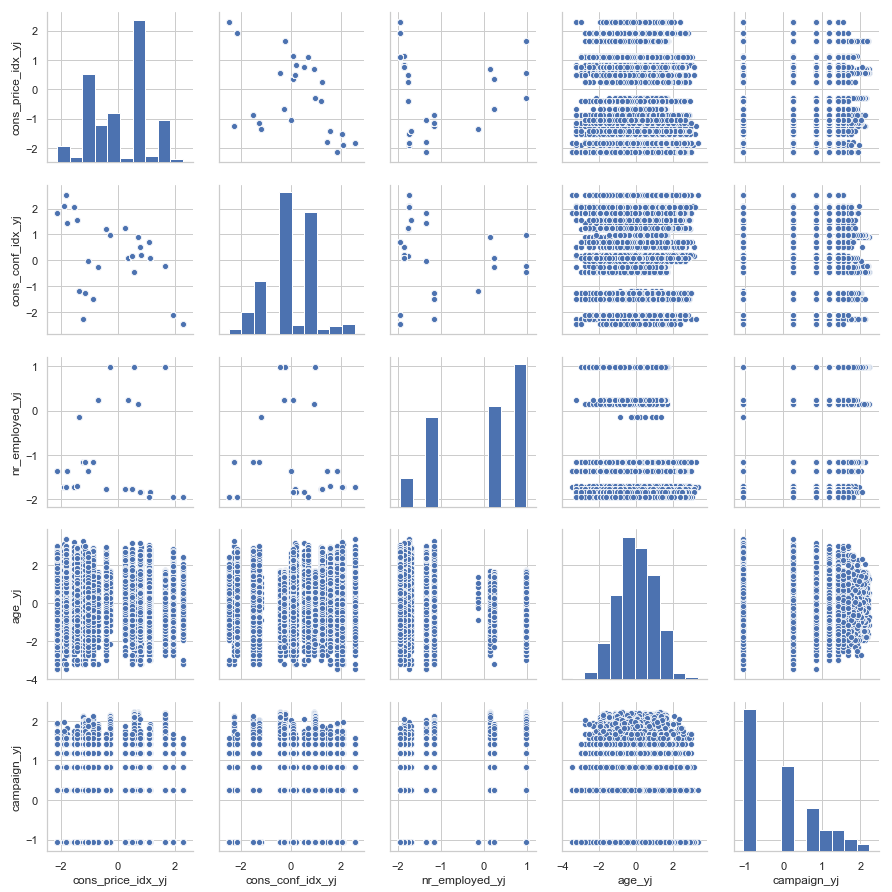

In [24]:
g = sns.pairplot(data=df_trans, vars=['cons_price_idx_yj', 'cons_conf_idx_yj',
                                      'nr_employed_yj', 'age_yj','campaign_yj'])

#### Concatenate: Put newly created standardized features into original dataframe, then drop non standardized.

In [25]:
df = pd.concat([df, df_trans], axis=1)

In [26]:
# DROPPING ORIGINAL PRE-TRANSFORMATION VARIABLES
df.drop("cons_price_idx", axis=1, inplace=True) 
df.drop("cons_conf_idx",  axis=1, inplace=True) 
df.drop("nr_employed",    axis=1, inplace=True)
df.drop("age",            axis=1, inplace=True)
df.drop("campaign",       axis=1, inplace=True) 

#### Check and remove any null rows with null values.

In [27]:
df.isnull().mean()

job                  0.000583
marital              0.000583
education            0.000583
housing              0.000583
loan                 0.000583
month                0.000583
day_of_week          0.000583
y                    0.000583
cons_price_idx_yj    0.000583
cons_conf_idx_yj     0.000583
nr_employed_yj       0.000583
age_yj               0.000583
campaign_yj          0.000583
dtype: float64

In [28]:
df=df.dropna();

In [29]:
df.describe()

,cons_price_idx_yj,cons_conf_idx_yj,nr_employed_yj,age_yj,campaign_yj
count,41140.000000,41140.000000,41140.000000,41140.000000,41140.000000
mean,0.000194,-0.000099,-0.000045,-0.000014,0.000020
std,1.000035,0.999914,0.999979,1.000069,0.999998
min,-2.144516,-2.483745,-1.941135,-3.486425,-1.045712
25%,-0.887169,-0.437496,-1.149177,-0.744517,-1.045712
50%,0.247939,-0.231759,0.140877,-0.052114,0.244677
75%,0.700587,0.911937,0.987226,0.773107,0.844668
max,2.284672,2.547010,0.987226,3.367289,2.233622


#### Create lists so can process numeric and categorical seperately.

In [30]:
# CONTINUOUS VARIABLE LIST
con_list_yj  = ['cons_price_idx_yj', 'cons_conf_idx_yj','nr_employed_yj', 
                'age_yj','campaign_yj']

# CATEGORICAL VARIABLE LIST
cat_list = ['job','marital','education','housing','loan','month','day_of_week']

#### Target variable = 'y'. Convert to binary 0 and 1.

In [31]:
# CHANGE NO AND YES TO 0 AND 1 
df['y'].replace(['no','yes'],[0,1],inplace=True)

## 2.C EDA - Data Exploration

#### Univariate Analysis

In [32]:
count_no      = len(df[df['y']==0]) # NO
count_yes     = len(df[df['y']==1]) # YES
pct_of_no_sub = round(count_no/(count_no+count_yes),2)
pct_of_sub    = round(count_yes/(count_no+count_yes),2)

print("% no  response to campaign", pct_of_no_sub*100)
print("% yes response to campaign", pct_of_sub*100)

df['y'].value_counts()

% no  response to campaign 89.0
% yes response to campaign 11.0


0    36513
1     4627
Name: y, dtype: int64

#### Analysis: 
* Dataset is not balanced with respect to (W.R.T) response variable y. 
* Will need to balance in order to reduce training errors.
* Will balance with minority oversampling technique, SMOTE

#### Continuous Variables:  
* Plot the mean value for feature when grouped W.R.T. "y", the target variable. This is the  conversion ratio.  
* Plot density with histogram.
* Plot outliers with box plot

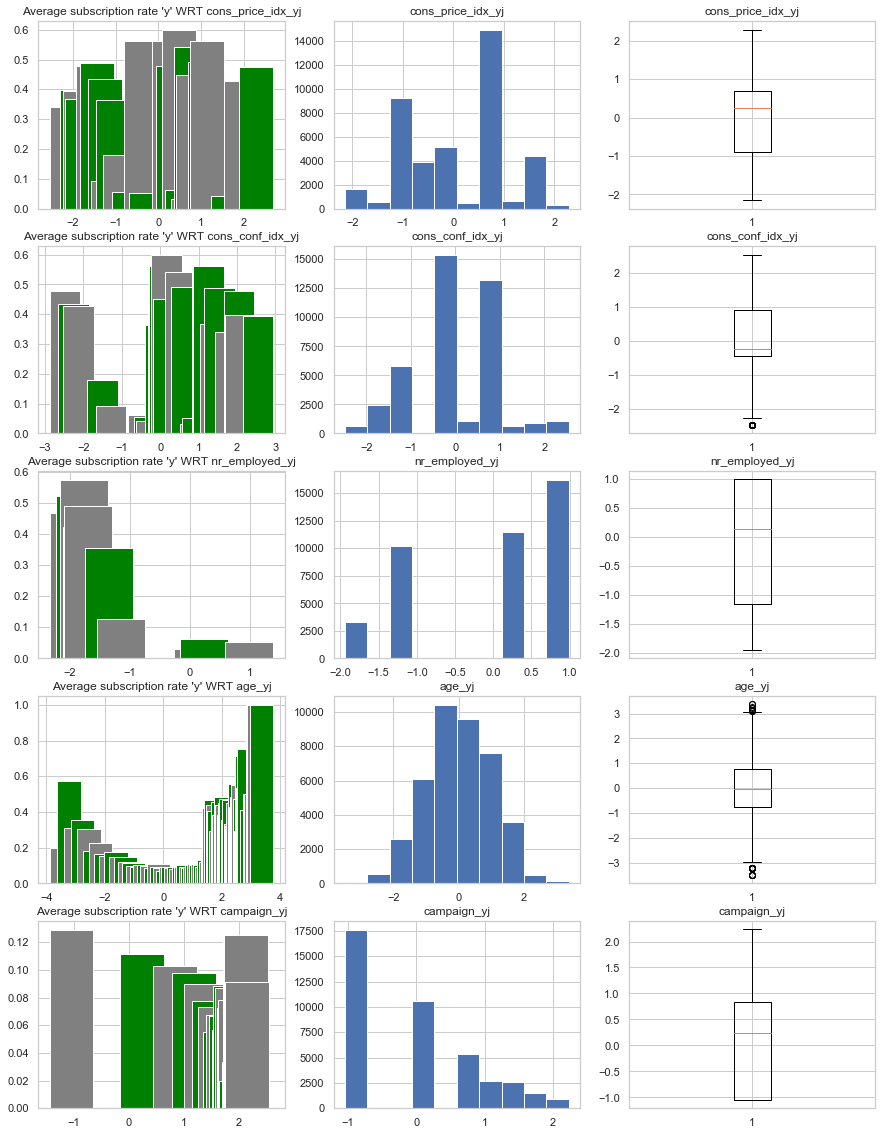

In [33]:
plt.figure(figsize=(15,20))

i=0
for column in con_list_yj:
    i = i + 1
    
    # BAR PLOT
    plt.subplot(5,3,i)
    plt.bar(df.groupby(column)["y"].mean().index,
             df.groupby(column)["y"].mean(), 
             color=("grey","green"))
    plt.title("Average subscription rate 'y' WRT {}".format(column)) 
    
    # DENSITY PLOT - HISTOGRAM
    i += 1
    plt.subplot(5, 3, i)
    plt.hist(df[column])
    plt.title("{}".format(column))   
    
    # TUKEY: DETECT OUTLIERS IN VARIABLES USING BOX PLOTS
    i += 1
    plt.subplot(5,3,i)
    plt.boxplot(df[column],whis=1.5)
    plt.title(column)

### Multivariate

#### Telemarketing conversion ratio by category

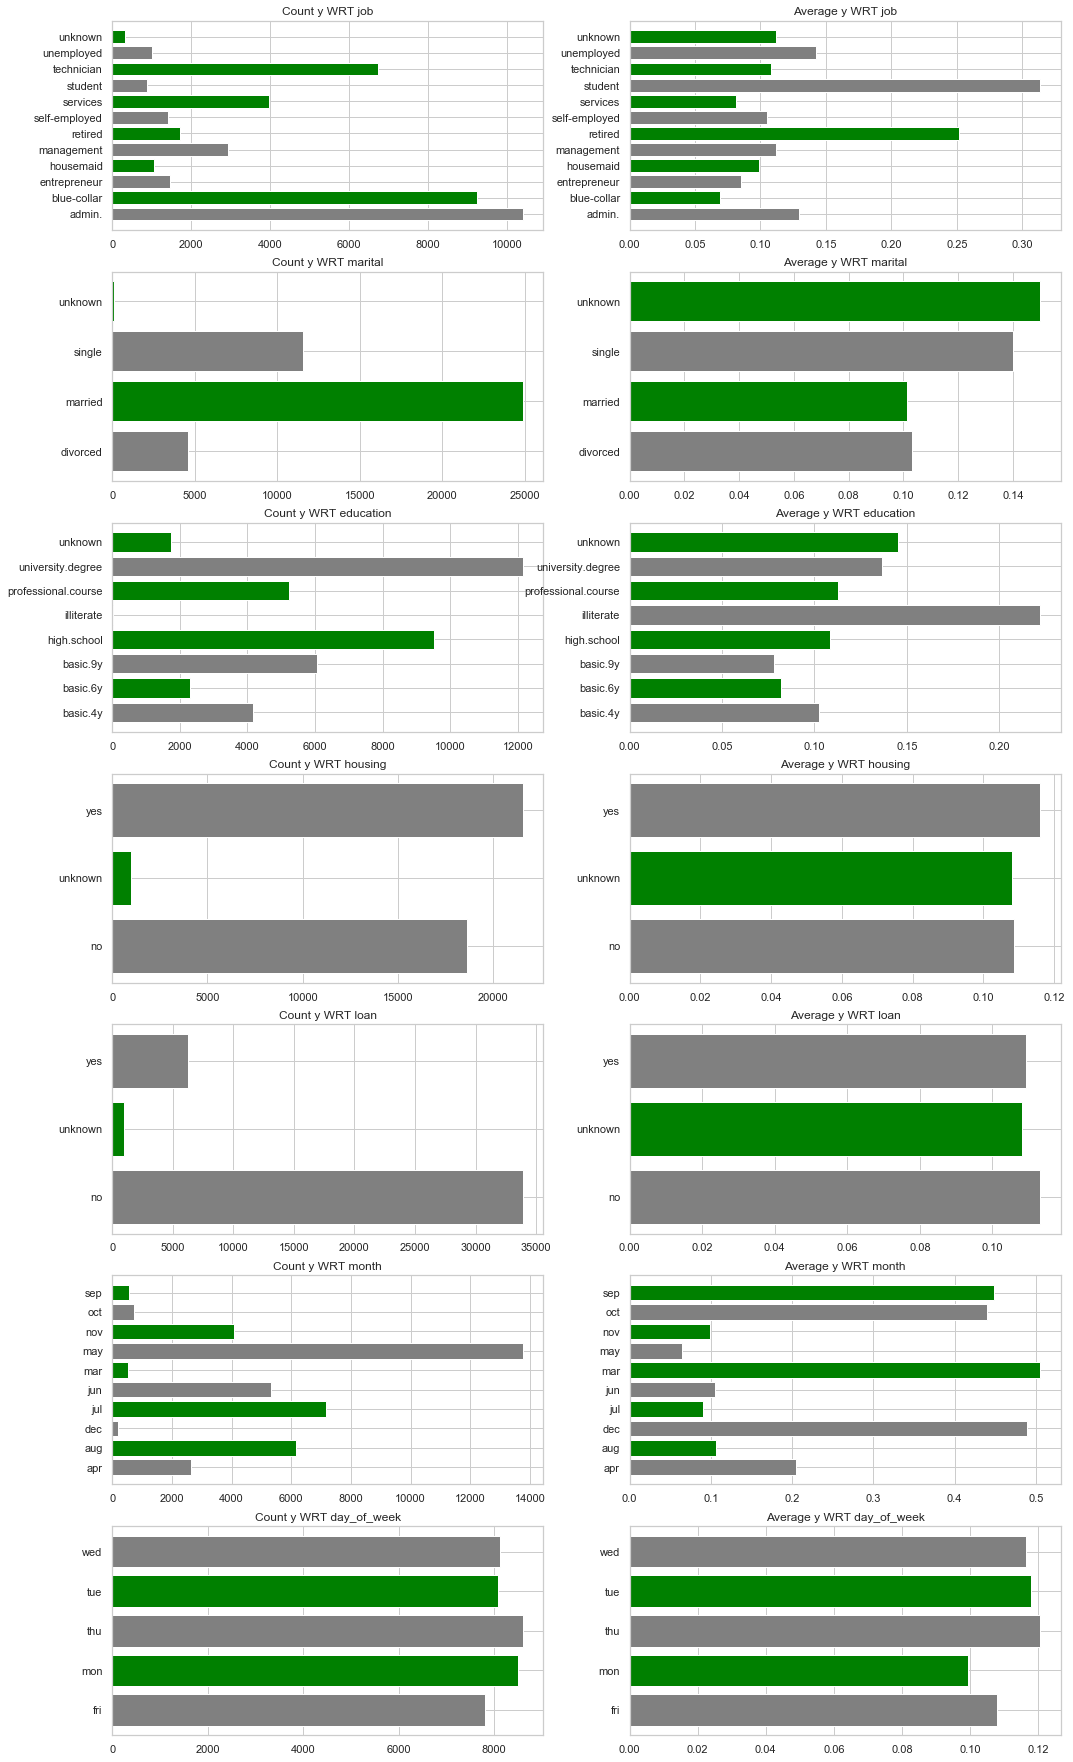

In [34]:
# TAKE THE MEAN OF RESPONSE VARIABLE AND PLOT WITH BAR CHART BY CATEGORY
plt.figure(figsize=(17,50))

i = 0
for column in df[cat_list].columns:
    i = i + 1
    plt.subplot(11,2,i)
    plt.barh(df.groupby(column)["y"].count().index,
             df.groupby(column)["y"].count(), 
             color=("grey","green"))
    plt.title("Count y WRT {}".format(column))  
    
    i = i + 1
    plt.subplot(11,2,i)
    plt.barh(df.groupby(column)["y"].mean().index,
             df.groupby(column)["y"].mean(), 
             color=("grey","green"))
    plt.title("Average y WRT {}".format(column)) 

In [35]:
df.head()

,job,marital,education,housing,loan,month,day_of_week,y,cons_price_idx_yj,cons_conf_idx_yj,nr_employed_yj,age_yj,campaign_yj
0,housemaid,married,basic.4y,no,no,may,mon,0,0.700587,0.911937,0.140877,1.427605,-1.045712
1,services,married,high.school,no,no,may,mon,0,0.700587,0.911937,0.140877,1.492446,-1.045712
2,services,married,high.school,yes,no,may,mon,0,0.700587,0.911937,0.140877,-0.158080,-1.045712
3,admin.,married,basic.6y,no,no,may,mon,0,0.700587,0.911937,0.140877,0.150171,-1.045712
4,services,married,high.school,no,yes,may,mon,0,0.700587,0.911937,0.140877,1.427605,-1.045712


#### Analysis: Conversion ratio by categories in each categorical variable.
* job -> High variance in conversion ratio on the whole. The categories with the high conversion ratio have fewer observations, while most observations are in four categories with smaller variance.
* marital -> not much variance in conversion ratio, high variance in observations, most people are married. 
* education -> high variance in conversion ratio, high variance in observations.
* housing -> low variance in conversion ratio, low variance in observations.
* loan -> low variance in conversion ratio, high variance in observations. Strong imbalance between no and yes classes. Since low variance, unlikely adding information.
* month -> high variance in conversion ratio, high variance in observations. Would appear number of observations is inversely related to conversion ratio. May be unpredictiable when applying to a new campaign unless legitimate drivers underly observations and conversion. Is it by choice, or random as to when bank chose to focus on campaigns for no significant reason?
* day_of_week -> mid to low variance in conversion ratio, low variance in observations. 

Would say that job, education, month, and day of week, and marital appear to provide information into prediction.

#### Alternative ways to view conversion ratio and the underlying

In [36]:
# CATEGORIES IN FEATURE W.R.T. y
df.groupby('loan')['y'].mean().sort_values(ascending=False)

loan
no         0.113176
yes        0.109332
unknown    0.108081
Name: y, dtype: float64

Text(0, 0.5, 'Frequency')

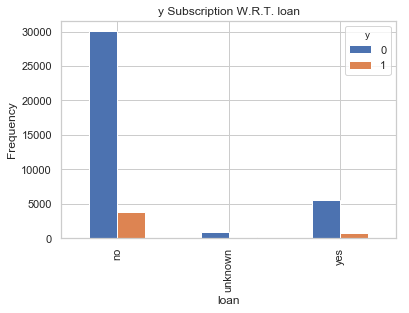

In [37]:
# LOOK AT THE CONVERSION RATIO WITH BAR CHART OF TARGET VARIABLE W.R.T. CATEGORICAL VARIABLE
pd.crosstab(df['loan'],df.y).plot(kind='bar')
plt.title('y Subscription W.R.T. loan')
plt.xlabel('loan')
plt.ylabel('Frequency')
#plt.savefig('y subscription wrt loan')

#### Check target count against numeric features.

In [38]:
# MEAN OF NUMERIC FEATURES W.R.T. y
df.groupby('y').mean()

,cons_price_idx_yj,cons_conf_idx_yj,nr_employed_yj,age_yj,campaign_yj
y,,,,,
0,0.045409,-0.014051,0.109575,-0.002923,0.020011
1,-0.356611,0.110005,-0.865088,0.022941,-0.157740


### One Hot Encoding
Convert categorical variables to binary 0 or 1 for each category. Drop first category.

In [39]:
one_hot_list_all = []

In [40]:
for feature in cat_list:
    df = pd.concat([df, pd.get_dummies(df[feature], prefix=feature, drop_first=True)], axis=1)
    one_hot_list_all.extend(list(pd.get_dummies(df[feature], prefix=feature, 
                                                drop_first=True).columns))
    df.drop(feature, axis=1, inplace=True) 

In [41]:
# EXPORT FILE TO USE IN TABLEAU
#df.to_csv(r'C:/Users/DJ/Desktop/marketing_Port_bank_pre_SMOTE.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path

### SMOTE - Systematic Minority Oversampling Technique

In [42]:
X = df.loc[:, df.columns != 'y']
y = df.loc[:, df.columns == 'y'].values.ravel()

In [43]:
os = SMOTE(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
columns = X_train.columns

os_data_X, os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])

# CHECK NUMBERS IN SMOTE DATA
print("{}\t Length of SMOTE data".format(len(os_data_X)))
print("{}\t Number of no subscription in SMOTE data".format(len(os_data_y[os_data_y['y']==0])))
print("{}\t Number of    subscription in SMOTE data".format(len(os_data_y[os_data_y['y']==1])))
print("{}\t Proportion of no subscription data in SMOTE data".format(len(os_data_y[os_data_y['y']==0])/len(os_data_X)))
print("{}\t Proportion of    subscription data in SMOTE data".format(len(os_data_y[os_data_y['y']==1])/len(os_data_X)))

48904	 Length of SMOTE data
24452	 Number of no subscription in SMOTE data
24452	 Number of    subscription in SMOTE data
0.5	 Proportion of no subscription data in SMOTE data
0.5	 Proportion of    subscription data in SMOTE data


## Part 2 Feature Selection and Dimension Reduction

### Base model to compare with feature selection and dimension reduction

In [44]:
# LogReg FOR BASE MODEL, IT WILL PERFORM WORSE WHEN LOW QUALITY FEATURES ARE INCLUDED
X = os_data_X 
y = os_data_y.values.ravel()

logreg = LogisticRegression(solver='lbfgs',max_iter=50000)
logreg_fit = logreg.fit(X, y)

# CROSS VALIDATION IN TRAIN SET 
score_fs_base = cross_val_score(logreg_fit, X, y, scoring="f1_weighted", cv=3)
print("mean={:.2f}   std=(+/- {:.2f})   all={} ".format(score_fs_base.mean(),
                                                    score_fs_base.std()*2, score_fs_base))

mean=0.73   std=(+/- 0.01)   all=[0.7314543  0.72333789 0.72964918] 


### Dimensionality Reduction: PCA 

In [45]:
X = os_data_X
y = os_data_y.values.ravel()
for i in range(1, 20, 1):
    pca = PCA(n_components = i)
    logreg = LogisticRegression(solver='lbfgs',max_iter=50000)
    pipeline = Pipeline([('pca', pca), ('logistic', logreg)])
    pipeline = pipeline.fit(X,y)
    score_fs_pca = cross_val_score(pipeline, X, y, scoring="f1_weighted", cv=3)
    print("mean={:.2f}   std=(+/- {:.2f})   all={} ".format(score_fs_pca.mean(),
                                                    score_fs_pca.std()*2, score_fs_pca))

mean=0.69   std=(+/- 0.00)   all=[0.69045282 0.68479358 0.68942988] 
mean=0.69   std=(+/- 0.00)   all=[0.69051442 0.68503821 0.68930599] 
mean=0.69   std=(+/- 0.01)   all=[0.69186018 0.68424957 0.68906559] 
mean=0.69   std=(+/- 0.01)   all=[0.69281491 0.68439737 0.6878364 ] 
mean=0.72   std=(+/- 0.01)   all=[0.7178252  0.71175313 0.71901837] 
mean=0.71   std=(+/- 0.01)   all=[0.7119272  0.70389853 0.71230322] 
mean=0.71   std=(+/- 0.01)   all=[0.7150981  0.70841294 0.71469434] 
mean=0.72   std=(+/- 0.01)   all=[0.71985326 0.71113202 0.71987839] 
mean=0.72   std=(+/- 0.01)   all=[0.72432569 0.72053374 0.7294909 ] 
mean=0.73   std=(+/- 0.01)   all=[0.7249968  0.72086291 0.73032861] 
mean=0.72   std=(+/- 0.01)   all=[0.72397237 0.71897258 0.72851398] 
mean=0.72   std=(+/- 0.01)   all=[0.7243698  0.71881695 0.72862136] 
mean=0.72   std=(+/- 0.01)   all=[0.72199523 0.71278779 0.72321202] 
mean=0.73   std=(+/- 0.01)   all=[0.72944781 0.72089897 0.72789103] 
mean=0.73   std=(+/- 0.01)   all=[

In [46]:
# SET PCA ABOVE 80% VARIANCE EXPLAINED, HOWEVER MANY COMPONENTS
selector = PCA(n_components=.8).fit(X,y)
# SELECT # COMPONENTS
#selector = PCA(n_components=10).fit(X,y)

var_explained = selector.explained_variance_ratio_ 
var_explained = pd.Series(var_explained)
print(round(var_explained,4)) 

0     0.2031
1     0.1542
2     0.1190
3     0.0967
4     0.0697
5     0.0446
6     0.0329
7     0.0254
8     0.0239
9     0.0226
10    0.0215
dtype: float64


In [47]:
pca = PCA(n_components = 10)
logreg = LogisticRegression(solver='lbfgs',max_iter=50000)
pipeline = Pipeline([('pca', pca), ('logistic', logreg)])
score_fs_pca = cross_val_score(pipeline, X, y, scoring="f1_weighted", cv=3)   
print("mean={:.2f}   std=(+/- {:.2f})   all={} ".format(score_fs_pca.mean(),
                                                        score_fs_pca.std()*2, score_fs_pca))

mean=0.73   std=(+/- 0.01)   all=[0.7249332  0.72092639 0.73032861] 


### Feature Selection: Univariate Filter Method - SelectKBest 
Continuous use f_classif (ANOVA)  
Categorical use chi2  

In [48]:
X = os_data_X[con_list_yj]
y = os_data_y.values.ravel()
for i in range(1,6,1):
    skb = SelectKBest(f_classif, k=i)
    logreg = LogisticRegression(solver='lbfgs',max_iter=50000)
    pipeline = Pipeline([('SelectKBest', skb), ('logistic', logreg)])
    pipeline = pipeline.fit(X,y)
    score_fs_skb = cross_val_score(pipeline, X, y, cv=3, scoring='f1_weighted')
    print("{}:\tmean={:.2f} std=(+/- {:.2f}) all={} ".format(i,score_fs_skb.mean(),
                                                           score_fs_skb.std()*2, score_fs_skb))

1:	mean=0.72 std=(+/- 0.01) all=[0.71935122 0.71248887 0.72134395] 
2:	mean=0.72 std=(+/- 0.01) all=[0.71935122 0.71248887 0.72134395] 
3:	mean=0.72 std=(+/- 0.01) all=[0.71935122 0.71255026 0.72140546] 
4:	mean=0.72 std=(+/- 0.01) all=[0.71935122 0.71248887 0.72134395] 
5:	mean=0.72 std=(+/- 0.01) all=[0.71935122 0.71248887 0.72134395] 


In [49]:
#### FIRST CONTINUOUS VARIABLE APPEARS TO HOLD ALL INFORMATION: nr_employed_yj
X = os_data_X[con_list_yj]
y = os_data_y.values.ravel()

selector = SelectKBest(f_classif, k=1).fit(X,y)

X_new = selector.transform(X)
X.columns[selector.get_support(indices=True)]
feature_skb_con = X.columns[selector.get_support(indices=True)].tolist()
print(sorted(feature_skb_con))

['nr_employed_yj']


In [50]:
#### WILL KEEP ALL CONTINUOUS VARIABLES IN CASE INFORMATION IS ADDED WHEN COMBINED WITH CATEGORICAL 
X = os_data_X[con_list_yj]
y = os_data_y.values.ravel()

selector = SelectKBest(f_classif, k=5).fit(X,y)

X_new = selector.transform(X)
X.columns[selector.get_support(indices=True)]
feature_skb_con = X.columns[selector.get_support(indices=True)].tolist()
print(sorted(feature_skb_con))

['age_yj', 'campaign_yj', 'cons_conf_idx_yj', 'cons_price_idx_yj', 'nr_employed_yj']


In [51]:
print(len(one_hot_list_all))

38


In [52]:
X = os_data_X[one_hot_list_all]
y = os_data_y.values.ravel()
for i in range(1,39,1):
    skb = SelectKBest(chi2, k=i)
    logreg = LogisticRegression(solver='lbfgs',max_iter=50000)
    pipeline = Pipeline([('SelectKBest', skb), ('logistic', logreg)])
    pipeline = pipeline.fit(X,y)
    score_fs_skb = cross_val_score(pipeline, X, y, cv=3, scoring ='f1_weighted')
    print("{}:\tmean={:.2f} std=(+/- {:.2f}) all={} ".format(i,score_fs_skb.mean(),
                                                           score_fs_skb.std()*2, score_fs_skb))

1:	mean=0.55 std=(+/- 0.00) all=[0.55202448 0.54935481 0.54855016] 
2:	mean=0.55 std=(+/- 0.00) all=[0.55166286 0.54862985 0.54829269] 
3:	mean=0.55 std=(+/- 0.00) all=[0.55093954 0.54728314 0.54679908] 
4:	mean=0.52 std=(+/- 0.00) all=[0.51434295 0.51313707 0.51864551] 
5:	mean=0.58 std=(+/- 0.01) all=[0.58991611 0.58136118 0.5827809 ] 
6:	mean=0.58 std=(+/- 0.01) all=[0.58509066 0.57708224 0.57759104] 
7:	mean=0.59 std=(+/- 0.00) all=[0.58692959 0.58928976 0.58989491] 
8:	mean=0.60 std=(+/- 0.04) all=[0.58692959 0.62613606 0.58930757] 
9:	mean=0.63 std=(+/- 0.01) all=[0.63241314 0.62686982 0.63324545] 
10:	mean=0.63 std=(+/- 0.02) all=[0.62782471 0.61478077 0.63370825] 
11:	mean=0.62 std=(+/- 0.01) all=[0.62824781 0.62681896 0.61721819] 
12:	mean=0.63 std=(+/- 0.01) all=[0.62963751 0.62715177 0.62178858] 
13:	mean=0.62 std=(+/- 0.01) all=[0.63122773 0.6187343  0.62344233] 
14:	mean=0.64 std=(+/- 0.01) all=[0.63790862 0.62992838 0.63913438] 
15:	mean=0.64 std=(+/- 0.01) all=[0.6384101

In [53]:
# HIGHEST PERFORMING CAT FEATURE: month_may
selector = SelectKBest(chi2, k=1).fit(X,y)
feature_skb_cat = X.columns[selector.get_support(indices=True)].tolist()
print(sorted(feature_skb_cat))

['month_may']


In [54]:
# 25 APPEARS TO BE WHERE STARTS TO PLATEAU WITH STABLE PERFORMANCE
selector = SelectKBest(chi2, k=25).fit(X,y)
feature_skb_cat = X.columns[selector.get_support(indices=True)].tolist()
print(sorted(feature_skb_cat))

['day_of_week_mon', 'education_basic.6y', 'education_basic.9y', 'education_university.degree', 'housing_unknown', 'housing_yes', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_unknown', 'loan_unknown', 'loan_yes', 'marital_married', 'marital_single', 'month_dec', 'month_jul', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep']


In [55]:
feature_skb = feature_skb_con + feature_skb_cat

In [56]:
print(len(feature_skb))

30


In [57]:
X = os_data_X[feature_skb]
y = os_data_y.values.ravel()
for i in range(1,31,1):
    skb = SelectKBest(f_classif, k=i)
    logreg = LogisticRegression(solver='lbfgs',max_iter=50000)
    pipeline = Pipeline([('SelectKBest', skb), ('logistic', logreg)])
    pipeline = pipeline.fit(X,y)
    score_fs_skb = cross_val_score(pipeline, X, y, cv=3, scoring ='f1_weighted')
    print("{}:\tmean={:.2f} std=(+/- {:.2f}) all={} ".format(i,score_fs_skb.mean(),
                                                           score_fs_skb.std()*2, score_fs_skb))

1:	mean=0.72 std=(+/- 0.01) all=[0.71935122 0.71248887 0.72134395] 
2:	mean=0.72 std=(+/- 0.01) all=[0.71935122 0.71248887 0.72134395] 
3:	mean=0.73 std=(+/- 0.01) all=[0.73027214 0.72368748 0.73134064] 
4:	mean=0.73 std=(+/- 0.01) all=[0.7306288  0.72366913 0.73114085] 
5:	mean=0.73 std=(+/- 0.01) all=[0.73056172 0.72779434 0.73395911] 
6:	mean=0.73 std=(+/- 0.01) all=[0.73496544 0.72779434 0.73395911] 
7:	mean=0.73 std=(+/- 0.01) all=[0.73508158 0.72753609 0.7337763 ] 
8:	mean=0.73 std=(+/- 0.01) all=[0.73415241 0.72695031 0.73247954] 
9:	mean=0.73 std=(+/- 0.01) all=[0.73380396 0.72695031 0.73378451] 
10:	mean=0.73 std=(+/- 0.01) all=[0.73187268 0.7264918  0.7327474 ] 
11:	mean=0.73 std=(+/- 0.01) all=[0.73440838 0.72642527 0.73300429] 
12:	mean=0.73 std=(+/- 0.01) all=[0.73439997 0.72592431 0.73331151] 
13:	mean=0.73 std=(+/- 0.01) all=[0.73349775 0.72600564 0.73146383] 
14:	mean=0.73 std=(+/- 0.01) all=[0.73349775 0.72593968 0.73101095] 
15:	mean=0.73 std=(+/- 0.01) all=[0.7341195

#### First two features give majority of perfromance, but for purposes of this study, and likely a more robust feature set, will keep top 30.

In [58]:
X = os_data_X[feature_skb]
y = os_data_y.values.ravel()
logreg = LogisticRegression(solver='lbfgs',max_iter=50000)
logreg_fit = logreg.fit(X, y)
score_fs_skb = cross_val_score(logreg_fit, X, y, scoring="f1_weighted", cv=3)
print("training f1_weighted\nmean={:.2f} std=(+/- {:.2f}) all={} ".format(score_fs_skb.mean(),
                                                              score_fs_skb.std()*2, score_fs_skb))

training f1_weighted
mean=0.73 std=(+/- 0.01) all=[0.72925983 0.72334514 0.72831718] 


### Feature Selection 2 - Embedded Method: Recursive Feature Elimination (RFE)
RFE Uses coef. for cutoff, can be unreliable.   
RFE woks like this, say if have 40+ attributes, and want 20, then with STEP=5 RFE would drop 5 lowest coefficients, then do 45, then 40, and so on. Step of 1 really low, lot of model building. RFE has CV, but is expensive. There is a way to rank RFE. 

In [59]:
start_time = time.time()

X = os_data_X
y = os_data_y.values.ravel()

for i in range(2,33,3):
    logreg = LogisticRegression(solver='lbfgs',max_iter=50000)
    rfe = RFE(logreg, i, step=1)
    pipeline = Pipeline([('RFE', rfe), ('logistic', logreg)])
    pipeline = pipeline.fit(X,y)
    
    score_fs_rfe = cross_val_score(pipeline, X, y, scoring="f1_weighted", cv=3)
    print("{}: training f1_weighted\nmean={:.2f} std=(+/- {:.2f}) all={} ".format(
        i, score_fs_rfe.mean(),score_fs_rfe.std()*2, score_fs_rfe))
print()
print("Elapsed Time:")
print("--- {:.2f} seconds ---".format(time.time() - start_time))
print("--- {:.2f} minutes ---".format((time.time() - start_time)/60))

2: training f1_weighted
mean=0.73 std=(+/- 0.01) all=[0.73094266 0.72449149 0.73200631] 
5: training f1_weighted
mean=0.73 std=(+/- 0.01) all=[0.73059832 0.72867033 0.73471374] 
8: training f1_weighted
mean=0.73 std=(+/- 0.01) all=[0.73122324 0.72487515 0.73482208] 
11: training f1_weighted
mean=0.73 std=(+/- 0.00) all=[0.73095501 0.72839488 0.73443203] 
14: training f1_weighted
mean=0.73 std=(+/- 0.01) all=[0.73095501 0.72785235 0.73436565] 
17: training f1_weighted
mean=0.73 std=(+/- 0.01) all=[0.73088795 0.72503847 0.73473128] 
20: training f1_weighted
mean=0.73 std=(+/- 0.01) all=[0.73095465 0.72240311 0.73145728] 
23: training f1_weighted
mean=0.73 std=(+/- 0.01) all=[0.73183743 0.72234664 0.72804186] 
26: training f1_weighted
mean=0.73 std=(+/- 0.01) all=[0.72936811 0.72399092 0.732006  ] 
29: training f1_weighted
mean=0.73 std=(+/- 0.01) all=[0.73159106 0.72499067 0.73528157] 
32: training f1_weighted
mean=0.73 std=(+/- 0.01) all=[0.72977764 0.72403327 0.73250521] 

Elapsed Time

In [60]:
# MODEL SPECIFIC, SVC MAY PUT DIFF VALUES ON FEATURES VS LOG REG
logreg = LogisticRegression(solver='lbfgs',max_iter=50000)
rfe = RFE(logreg, 30, step=1)
rfe = rfe.fit(X, y)

score_fs_rfe = cross_val_score(logreg, X, y, scoring="f1_weighted", cv=3)
#print("weighted: {}   all: {}".format(round(score_fs_rfe.mean(),3),score_fs_rfe))
print("training f1_weighted\nmean={:.2f} std=(+/- {:.2f}) all={} ".format(
    score_fs_rfe.mean(), score_fs_rfe.std()*2, score_fs_rfe))
feat_scores_rfe = pd.DataFrame()
feat_scores_rfe["ranking"] = rfe.ranking_
feat_scores_rfe["support"] = rfe.support_
feat_scores_rfe["Attribute"] = X.columns

training f1_weighted
mean=0.73 std=(+/- 0.01) all=[0.7314543  0.72333789 0.72964918] 


In [61]:
df_num_features=feat_scores_rfe[feat_scores_rfe['ranking'] == 1]
feature_rfe = df_num_features['Attribute'].tolist()
print(sorted(feature_rfe))

['day_of_week_mon', 'education_basic.6y', 'education_basic.9y', 'education_illiterate', 'education_professional.course', 'education_unknown', 'housing_unknown', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_self-employed', 'job_services', 'job_technician', 'job_unemployed', 'job_unknown', 'loan_unknown', 'loan_yes', 'marital_married', 'marital_single', 'marital_unknown', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_oct', 'month_sep', 'nr_employed_yj']


In [62]:
print(len(feature_rfe))

30


In [63]:
feat_scores_rfe.sort_values(by='ranking', ascending=True).head(30)

,ranking,support,Attribute
18,1,True,marital_unknown
29,1,True,loan_yes
28,1,True,loan_unknown
37,1,True,month_oct
26,1,True,housing_unknown
25,1,True,education_unknown
32,1,True,month_jul
23,1,True,education_professional.course
22,1,True,education_illiterate
20,1,True,education_basic.9y


#### Worth noting, "unknown" categories in categorical variables are considered predictive.

### Feature Selection 3: Feature Importance Embedding Method - Extra Trees Classifier  

In [64]:
X = os_data_X
y = os_data_y.values.ravel()

etc_classifier = ExtraTreesClassifier(n_estimators=100)
etc_classifier = etc_classifier.fit(X, y)

feat_scores_etc = pd.DataFrame()
feat_scores_etc["feature_importances"] = etc_classifier.feature_importances_
feat_scores_etc["feature_importances"] = round(feat_scores_etc["feature_importances"],4)
feat_scores_etc["Attribute"] = X.columns

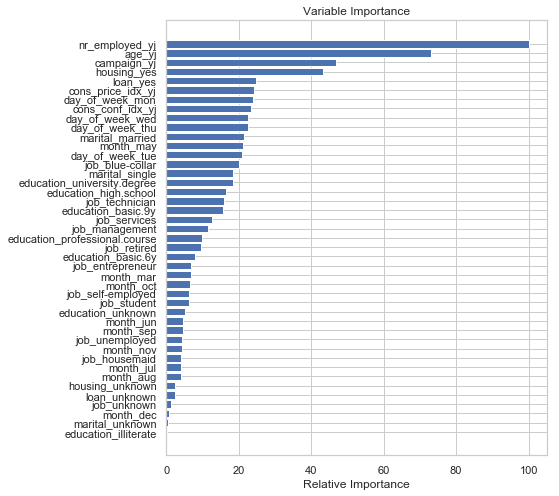

In [65]:
feature_importance = etc_classifier.feature_importances_
plt.figure(figsize=(15,8))

# MAKE IMPORTANCES RELATIVE TO MAX IMPORTANCE
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [66]:
# SELECT FEATURE IMPORTANCES > X%
df_gt_thresh_etc = feat_scores_etc[feat_scores_etc['feature_importances']>.0081].sort_values(
    by='feature_importances', ascending=False)
feature_etc = df_gt_thresh_etc['Attribute'].tolist()
print(feature_etc)

['nr_employed_yj', 'age_yj', 'campaign_yj', 'housing_yes', 'loan_yes', 'cons_price_idx_yj', 'day_of_week_mon', 'cons_conf_idx_yj', 'day_of_week_wed', 'day_of_week_thu', 'marital_married', 'month_may', 'day_of_week_tue', 'job_blue-collar', 'marital_single', 'education_university.degree', 'education_high.school', 'job_technician', 'education_basic.9y', 'job_services', 'job_management', 'education_professional.course', 'job_retired', 'education_basic.6y', 'job_entrepreneur', 'month_mar', 'month_oct', 'job_self-employed', 'job_student']


In [67]:
print(len(feature_etc))

29


#### Worth noting, ETC does not include unknown category in categorical variables, and top two variables are continuous. ETC appears to favor continuous variables.

#### Feature Importances For ExtraTreeClassifier > Threshold

In [68]:
start_time = time.time()

X = os_data_X[feature_etc]
y = os_data_y.values.ravel()

logreg = LogisticRegression(solver='lbfgs',max_iter=50000).fit(X,y)
score_fs_etc = cross_val_score(logreg, X, y, scoring="f1_weighted", cv=3)

#print("weighted f1: {:.2f}   all: {}".format(round(score_fs_etc.mean(),3),score_fs_etc))
print("training f1_weighted\nmean={:.2f} std=(+/- {:.2f}) all={} ".format(
    score_fs_etc.mean(),score_fs_etc.std()*2, score_fs_etc))
print()
print("Elapsed Time:")
print("--- {:.2f} seconds ---".format(time.time() - start_time))
print("--- {:.2f} minutes ---".format((time.time() - start_time)/60))

training f1_weighted
mean=0.73 std=(+/- 0.01) all=[0.7308034  0.72400538 0.72988552] 

Elapsed Time:
--- 0.88 seconds ---
--- 0.01 minutes ---


### Summary of training results for dimension reduction and feature selection

In [69]:
print("Base: f1_weighted\t mean={:.2f} std=(+/- {:.2f}) all={} ".format(
    score_fs_base.mean(),score_fs_base.std()*2, score_fs_base))
print("PCA:  f1_weighted\t mean={:.2f} std=(+/- {:.2f}) all={} ".format(
    score_fs_pca.mean(),score_fs_pca.std()*2, score_fs_pca))
print("SKB:  f1_weighted\t mean={:.2f} std=(+/- {:.2f}) all={} ".format(
    score_fs_skb.mean(),score_fs_skb.std()*2, score_fs_skb))
print("RFE:  f1_weighted\t mean={:.2f} std=(+/- {:.2f}) all={} ".format(
    score_fs_rfe.mean(),score_fs_rfe.std()*2, score_fs_rfe))
print("ETC:  f1_weighted\t mean={:.2f} std=(+/- {:.2f}) all={} ".format(
    score_fs_etc.mean(),score_fs_etc.std()*2, score_fs_etc))

Base: f1_weighted	 mean=0.73 std=(+/- 0.01) all=[0.7314543  0.72333789 0.72964918] 
PCA:  f1_weighted	 mean=0.73 std=(+/- 0.01) all=[0.7249332  0.72092639 0.73032861] 
SKB:  f1_weighted	 mean=0.73 std=(+/- 0.01) all=[0.72925983 0.72334514 0.72831718] 
RFE:  f1_weighted	 mean=0.73 std=(+/- 0.01) all=[0.7314543  0.72333789 0.72964918] 
ETC:  f1_weighted	 mean=0.73 std=(+/- 0.01) all=[0.7308034  0.72400538 0.72988552] 


In [70]:
print(len(feature_skb))
print(len(feature_rfe))
print(len(feature_etc))

30
30
29


#### Analysis: SKB, RFE, and ETC match the performance of the Base model. As prefer performance to meet or exceed the base model, this is a good sign.

In [71]:
print(sorted(feature_skb))

['age_yj', 'campaign_yj', 'cons_conf_idx_yj', 'cons_price_idx_yj', 'day_of_week_mon', 'education_basic.6y', 'education_basic.9y', 'education_university.degree', 'housing_unknown', 'housing_yes', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_unknown', 'loan_unknown', 'loan_yes', 'marital_married', 'marital_single', 'month_dec', 'month_jul', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'nr_employed_yj']


In [72]:
print(sorted(feature_rfe))

['day_of_week_mon', 'education_basic.6y', 'education_basic.9y', 'education_illiterate', 'education_professional.course', 'education_unknown', 'housing_unknown', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_self-employed', 'job_services', 'job_technician', 'job_unemployed', 'job_unknown', 'loan_unknown', 'loan_yes', 'marital_married', 'marital_single', 'marital_unknown', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_oct', 'month_sep', 'nr_employed_yj']


In [73]:
print(sorted(feature_etc))

['age_yj', 'campaign_yj', 'cons_conf_idx_yj', 'cons_price_idx_yj', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_professional.course', 'education_university.degree', 'housing_yes', 'job_blue-collar', 'job_entrepreneur', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'loan_yes', 'marital_married', 'marital_single', 'month_mar', 'month_may', 'month_oct', 'nr_employed_yj']


## Part 3: Models

### Model 1: Logistic Regression

In [74]:
start_time = time.time()
print("Start Time: {}".format(time.ctime()))

X = os_data_X[feature_skb]
y = os_data_y['y'].values.ravel()

clf_lr = LogisticRegression(solver='newton-cg', max_iter=50000) # USUALLY lbfgs REVIEW

# LESS THAN ONE MINUTE TO RUN
# IDENTIFY BEST PARAMETERS WITH GridSearchCV
#search_grid = { 
#    'solver': ['liblinear', 'newton-cg', 'saga','lbfgs'],
#    'C': [.001,.01,0.1,1,10,100,1000]
#}

search_grid = { 
    'solver': ['liblinear'],
    'C': [1]
}

clf_lr_cv_skb = GridSearchCV(estimator=clf_lr, param_grid=search_grid, cv=3, 
                             scoring='f1_weighted')
clf_lr_cv_skb.fit(X, y);

print("Elapsed Time:")
print("--- {:.2f} seconds ---".format(time.time() - start_time))
print("--- {:.2f} minutes ---".format((time.time() - start_time)/60))
print()

Start Time: Mon Mar 23 15:06:12 2020
Elapsed Time:
--- 1.02 seconds ---
--- 0.02 minutes ---



In [75]:
start_time = time.time()
print("Start Time: {}".format(time.ctime()))

X = os_data_X
y = os_data_y['y'].values.ravel()

pca = PCA(n_components = 10)
logreg = LogisticRegression(solver='newton-cg',max_iter=50000,C=1)
clf_lr = Pipeline([('pca', pca), ('logistic', logreg)])

# LESS THAN ONE MINUTE TO RUN
# IDENTIFY BEST PARAMETERS WITH GridSearchCV
#search_grid = { 
#    'logistic__solver': ['liblinear', 'newton-cg', 'saga','lbfgs'],
#    'logistic__C': [.001,.01,0.1,1,10,100,1000]
#}

search_grid = { 
    'logistic__solver': ['newton-cg'],
    'logistic__C': [.01]
}

clf_lr_cv_pca = GridSearchCV(estimator=clf_lr, param_grid=search_grid, cv=3,scoring='f1_weighted')
clf_lr_cv_pca.fit(X, y)

#print(clf_lr.get_params().keys())

print("Elapsed Time:")
print("--- {:.2f} seconds ---".format(time.time() - start_time))
print("--- {:.2f} minutes ---".format((time.time() - start_time)/60))

Start Time: Mon Mar 23 15:06:13 2020
Elapsed Time:
--- 1.66 seconds ---
--- 0.03 minutes ---


In [76]:
start_time = time.time()
print("Start Time: {}".format(time.ctime()))

X = os_data_X[feature_rfe]
y = os_data_y['y'].values.ravel()

clf_lr = LogisticRegression(solver='liblinear', max_iter=50000) # USUALLY lbfgs REVIEW

#search_grid = { 
#    'solver': ['liblinear', 'newton-cg', 'saga','lbfgs'],
#    'C': [.001,.01,0.1,1,10,100,1000]
#}

# LESS THAN ONE MINUTE TO RUN
# IDENTIFY BEST PARAMETERS WITH GridSearchCV
search_grid = { 
    'solver': ['liblinear'],
    'C': [1000]
}

clf_lr_cv_rfe = GridSearchCV(estimator=clf_lr, param_grid=search_grid, cv=3,scoring='f1_weighted')
clf_lr_cv_rfe.fit(X, y);

print("Elapsed Time:")
print("--- {:.2f} seconds ---".format(time.time() - start_time))
print("--- {:.2f} minutes ---".format((time.time() - start_time)/60))

Start Time: Mon Mar 23 15:06:14 2020
Elapsed Time:
--- 0.75 seconds ---
--- 0.01 minutes ---


In [77]:
start_time = time.time()
print("Start Time: {}".format(time.ctime()))

X = os_data_X[feature_etc]
y = os_data_y['y'].values.ravel()

clf_lr = LogisticRegression(solver='lbfgs', max_iter=50000) # USUALLY lbfgs REVIEW

# LESS THAN ONE MINUTE TO RUN
# IDENTIFY BEST PARAMETERS WITH GridSearchCV
#search_grid = { 
#    'solver': ['liblinear', 'newton-cg', 'saga','lbfgs'],
#    'C': [.001,.01,0.1,1,10,100,1000]
#}

search_grid = { 
    'solver': ['liblinear'],
    'C': [.01]
} 

clf_lr_cv_etc = GridSearchCV(estimator=clf_lr, param_grid=search_grid, cv=3, scoring='f1_weighted')
clf_lr_cv_etc.fit(X, y);

print("Elapsed Time:")
print("--- {:.2f} seconds ---".format(time.time() - start_time))
print("--- {:.2f} minutes ---".format((time.time() - start_time)/60))

Start Time: Mon Mar 23 15:06:15 2020
Elapsed Time:
--- 0.82 seconds ---
--- 0.01 minutes ---


In [78]:
print("Accuracy Best Paramaters GridSearchCV:")
print("\tSelectKBest:\t\t\t{:.3f}".format(              clf_lr_cv_skb.best_score_))
print("\tRecursive Feature Elimination:\t{:.3f}".format(clf_lr_cv_rfe.best_score_))
print("\tExtraTreesClassifer:\t\t{:.3f}".format(        clf_lr_cv_etc.best_score_))
print("\tPrincipal Component Analysis:\t{:.3f}".format( clf_lr_cv_pca.best_score_))
print()
print("Best Paramaters GridSearchCV:")
print("SKB: {}".format(clf_lr_cv_skb.best_params_))
print("RFE: {}".format(clf_lr_cv_rfe.best_params_))
print("ETC: {}".format(clf_lr_cv_etc.best_params_))
print("PCA: {}".format(clf_lr_cv_pca.best_params_))

Accuracy Best Paramaters GridSearchCV:
	SelectKBest:			0.727
	Recursive Feature Elimination:	0.730
	ExtraTreesClassifer:		0.728
	Principal Component Analysis:	0.725

Best Paramaters GridSearchCV:
SKB: {'C': 1, 'solver': 'liblinear'}
RFE: {'C': 1000, 'solver': 'liblinear'}
ETC: {'C': 0.01, 'solver': 'liblinear'}
PCA: {'logistic__C': 0.01, 'logistic__solver': 'newton-cg'}


#### Did GridSearchCV and these were results for best performing parameters

Accuracy Best Paramaters GridSearchCV:  
	SelectKBest:			        0.730  
	Recursive Feature Elimination:	0.738  
	ExtraTreesClassifer:		    0.733  
	Principal Component Analysis:	0.730  

Best Paramaters GridSearchCV:  

SKB: {'C': 1, 'solver': 'liblinear'}  
RFE: {'C': 1000, 'solver': 'liblinear'}  
ETC: {'C': 0.01, 'solver': 'liblinear'}  
PCA: {'logistic__C': 0.01, 'logistic__solver': 'newton-cg'}  

RFE threw some warning, which are likely due to selecting all "no". Thus its score will be thrown out, when selecting best parameters. As ETC was highest with no errors, will use ETC to represent LR.

ETC: {'C': 0.01, 'solver': 'liblinear'} 

#### Note, as Logistic Regression was used in feature set selection, it has a potential issue with curve fitting.

### Model 2 - Random Forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [79]:
start_time = time.time()
print("Start Time: {}".format(time.ctime()))

X = os_data_X[feature_skb]
y = os_data_y['y'].values.ravel()

clf_rfc = ensemble.RandomForestClassifier(criterion='gini', n_estimators=1000, max_features='log2', 
                                          max_depth=4, n_jobs=-1) 
# SIX MINUTES TO RUN
#parameter_candidates = { 
#    'n_estimators': [1000, 2000],
#    'max_features': ['sqrt','log2'],
#    'criterion': ['gini'],
#    'max_depth': [1,2,3,4]
#}
parameter_candidates = { 
    'criterion': ['gini'],
    'n_estimators': [1000],
    'max_features': ['log2'],
    'max_depth': [4]
}
clf_rfc_cv_skb = GridSearchCV(estimator=clf_rfc, param_grid=parameter_candidates, cv=3, 
                              scoring='f1_weighted')
clf_rfc_cv_skb.fit(X, y);

print("Elapsed Time:")
print("--- {:.2f} seconds ---".format(time.time() - start_time))
print("--- {:.2f} minutes ---".format((time.time() - start_time)/60))

Start Time: Mon Mar 23 15:06:16 2020
Elapsed Time:
--- 48.21 seconds ---
--- 0.80 minutes ---


In [80]:
start_time = time.time()
print("Start Time: {}".format(time.ctime()))

pca = PCA(n_components = 10)
clf_rfc = ensemble.RandomForestClassifier(criterion='gini', n_estimators=2000, max_features='log2',
                                          max_depth=4, n_jobs=-1) 
clf_rfc = Pipeline([('pca', pca), ('clf', clf_rfc)])

# 27.3 MINUTES TO RUN
#parameter_candidates = { 
#    'clf__n_estimators': [1000,2000],
#    'clf__max_features': ['sqrt','log2'],
#    'clf__criterion': ['gini'],
#    'clf__max_depth': [2,3,4],
#    'pca__n_components': [4,6,8,10]
#}
parameter_candidates = { 
    'clf__criterion': ['gini'],
    'clf__n_estimators': [2000],
    'clf__max_features': ['log2'],
    'clf__max_depth': [4],
    'pca__n_components': [10]
}

clf_rfc_cv_pca = GridSearchCV(estimator=clf_rfc, param_grid=parameter_candidates, cv=3, 
                              scoring='f1_weighted')
clf_rfc_cv_pca.fit(X, y)
#print(clf_lr.get_params().keys())

print("Elapsed Time:")
print("--- {:.2f} seconds ---".format(time.time() - start_time))
print("--- {:.2f} minutes ---".format((time.time() - start_time)/60))

Start Time: Mon Mar 23 15:07:04 2020
Elapsed Time:
--- 182.67 seconds ---
--- 3.04 minutes ---


In [81]:
start_time = time.time()
print("Start Time: {}".format(time.ctime()))

X = os_data_X[feature_rfe]
X_test_top = X_test[feature_rfe]

clf_rfc = ensemble.RandomForestClassifier(criterion='gini', n_estimators=1000, max_features='log2',
                                          max_depth=4, n_jobs=-1) 
# SIX AND A HALF MINUTES TO RUN
#parameter_candidates = { 
#    'n_estimators': [1000, 2000],
#    'max_features': ['sqrt','log2'],
#    'criterion': ['gini'],
#    'max_depth': [1,2,3,4]
#}
parameter_candidates = { 
    'criterion': ['gini'],
    'n_estimators': [1000],
    'max_features': ['log2'],
    'max_depth': [4]
}

clf_rfc_cv_rfe = GridSearchCV(estimator=clf_rfc, param_grid=parameter_candidates, cv=3,
                              scoring='f1_weighted')
clf_rfc_cv_rfe.fit(X, y)

print("Elapsed Time:")
print("--- {:.2f} seconds ---".format(time.time() - start_time))
print("--- {:.2f} minutes ---".format((time.time() - start_time)/60))

Start Time: Mon Mar 23 15:10:07 2020
Elapsed Time:
--- 41.93 seconds ---
--- 0.70 minutes ---


In [82]:
start_time = time.time()
print("Start Time: {}".format(time.ctime()))

X = os_data_X[feature_etc]
y = os_data_y['y'].values.ravel()

clf_rfc = ensemble.RandomForestClassifier(criterion='gini', n_estimators=2000, 
                                          max_features='log2', max_depth=4, n_jobs=-1) 
# LESS THAN SIX AND A HALF MINUTES TO RUN
#parameter_candidates = { 
#    'n_estimators': [1000, 2000],
#    'max_features': ['sqrt','log2'],
#    'criterion': ['gini'],
#    'max_depth': [1,2,3,4]
#}
parameter_candidates = { 
    'criterion': ['gini'],
    'n_estimators': [2000],
    'max_features': ['log2'],
    'max_depth': [4]
}

clf_rfc_cv_etc = GridSearchCV(estimator=clf_rfc, param_grid=parameter_candidates, cv=3, 
                              scoring='f1_weighted')
clf_rfc_cv_etc.fit(X, y)

print("Elapsed Time:")
print("--- {:.2f} seconds ---".format(time.time() - start_time))
print("--- {:.2f} minutes ---".format((time.time() - start_time)/60))

Start Time: Mon Mar 23 15:10:49 2020
Elapsed Time:
--- 84.06 seconds ---
--- 1.40 minutes ---


In [83]:
print("Accuracy Best Paramaters GridSearchCV:")
print("SelectKBest:\t\t\t{:.3f}".format(clf_rfc_cv_skb.best_score_))
print("Recursive Feature Elimination:\t{:.3f}".format(clf_rfc_cv_rfe.best_score_))
print("ExtraTreesClassifer:\t\t{:.3f}".format(clf_rfc_cv_etc.best_score_))
print("Principal Component Analysis:\t{:.3f}".format(clf_rfc_cv_pca.best_score_))
print()
print("Best Paramaters GridSearchCV:")
print("SKB:{}".format(clf_rfc_cv_skb.best_params_))
print("RFE:{}".format(clf_rfc_cv_rfe.best_params_))
print("ETC:{}".format(clf_rfc_cv_etc.best_params_))
print("PCA:{}".format(clf_rfc_cv_pca.best_params_))

Accuracy Best Paramaters GridSearchCV:
SelectKBest:			0.750
Recursive Feature Elimination:	0.759
ExtraTreesClassifer:		0.752
Principal Component Analysis:	0.734

Best Paramaters GridSearchCV:
SKB:{'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 1000}
RFE:{'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 1000}
ETC:{'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 2000}
PCA:{'clf__criterion': 'gini', 'clf__max_depth': 4, 'clf__max_features': 'log2', 'clf__n_estimators': 2000, 'pca__n_components': 10}


#### Analysis: 
Recursive feature analysis has best performance of all by significant margin.   

Accuracy Best Paramaters GridSearchCV:  
SelectKBest:			0.752  
Recursive Feature Elimination:	0.773  
ExtraTreesClassifer:		0.755  
Principal Component Analysis:	0.726  

Best Paramaters GridSearchCV:  
SKB:{'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 1000}  
RFE:{'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 1000}  
ETC:{'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 2000}  
PCA:{'clf__criterion': 'gini', 'clf__max_depth': 4, 'clf__max_features': 'log2', 'clf__n_estimators': 1000, 'pca__n_components': 10}  

### Model 3 - Support Vector Machine

In [84]:
start_time = time.time()
print("Start Time: {}".format(time.ctime()))

X = os_data_X[feature_skb]
X_test_top = X_test[feature_skb]
y = os_data_y['y'].values.ravel()
y_test = y_test

clf_svc = SVC(C=.01, kernel='linear')

# SHORT TIME TO RUN, FEW MIN
parameter_candidates = [
  {'C': [.01], 'kernel': ['linear']},
]

# 77 MINUTES TO RUN  # TRY POLYNOMIAL KERNAL IF TWO DIMENSIONAL PCA GRAPH IS LOOKS LIKE 
#parameter_candidates = [
#  {'C': [.01, 1, 10], 'kernel': ['linear']}
#  {'C': [.01, 1, 10], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
#]

# CREATE CLASSIFIER OBJECT AND SEARCH FOR BEST PARAMATER SETTINGS WITH GridSearchCV
clf_svc_cv_skb = GridSearchCV(estimator=clf_svc, param_grid=parameter_candidates, cv=3, 
                              scoring='f1_weighted')
clf_svc_cv_skb.fit(X, y);

print("Elapsed Time:")
print("--- {:.2f} seconds ---".format(time.time() - start_time))
print("--- {:.2f} minutes ---".format((time.time() - start_time)/60))

Start Time: Mon Mar 23 15:12:13 2020
Elapsed Time:
--- 221.10 seconds ---
--- 3.68 minutes ---


In [85]:
start_time = time.time()
print("Start Time: {}".format(time.ctime()))

X = os_data_X
X_test_top = X_test

pca = PCA(n_components = 10)
clf_svc = SVC(C=.01, kernel='linear')
clf_svc = Pipeline([('pca', pca), ('logistic', clf_svc)])

# SHORT TIME TO RUN, FEW MIN
parameter_candidates = [
  {'logistic__C': [.01], 'logistic__kernel': ['linear']},
]

# 77 MINUTES TO RUN
#parameter_candidates = [
#  {'logistic__C': [.01, 1, 10], 'logistic__kernel': ['linear']},
#  {'logistic__C': [.01, 1, 10], 'logistic__gamma': [0.001, 0.0001], 
#   'logistic__kernel': ['rbf'], 'pca__n_components': [3,4,5]},
#]

# CREATE CLASSIFIER OBJECT AND SEARCH FOR BEST PARAMATER SETTINGS WITH GridSearchCV
clf_svc_cv_pca = GridSearchCV(estimator=clf_svc, param_grid=parameter_candidates, cv=3, 
                              scoring='f1_weighted')
clf_svc_cv_pca.fit(X, y);

print("Elapsed Time:")
print("--- {:.2f} seconds ---".format(time.time() - start_time))
print("--- {:.2f} minutes ---".format((time.time() - start_time)/60))

Start Time: Mon Mar 23 15:15:54 2020
Elapsed Time:
--- 140.91 seconds ---
--- 2.35 minutes ---


In [86]:
start_time = time.time()
print("Start Time: {}".format(time.ctime()))

X = os_data_X[feature_rfe]
X_test_top = X_test[feature_rfe]

clf_svc = SVC(C=.01, kernel='linear')

# SHORT TIME TO RUN, FEW MIN
parameter_candidates = [
  {'C': [.01], 'kernel': ['linear']},
]

# 77 MINUTES TO RUN
#parameter_candidates = [
#  {'C': [.01, 10, 1000], 'kernel': ['linear']},
#  {'C': [.01, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
#]

# CREATE CLASSIFIER OBJECT AND SEARCH FOR BEST PARAMATER SETTINGS WITH GridSearchCV
clf_svc_cv_rfe = GridSearchCV(estimator=clf_svc, param_grid=parameter_candidates, cv=3, 
                              scoring='f1_weighted')
clf_svc_cv_rfe.fit(X, y);

print("Elapsed Time:")
print("--- {:.2f} seconds ---".format(time.time() - start_time))
print("--- {:.2f} minutes ---".format((time.time() - start_time)/60))

Start Time: Mon Mar 23 15:18:15 2020
Elapsed Time:
--- 215.76 seconds ---
--- 3.60 minutes ---


In [87]:
start_time = time.time()
print("Start Time: {}".format(time.ctime()))

X = os_data_X[feature_etc]
X_test_top = X_test[feature_etc]

clf_svc = SVC(C=.01, kernel='linear')

# SHORT TIME TO RUN, FEW MIN
parameter_candidates = [
  {'C': [.01], 'kernel': ['linear']},
]
# 77 MINUTES TO RUN
#parameter_candidates = [
#  {'C': [.01, 10, 1000], 'kernel': ['linear']},
#  {'C': [.01, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
#]

# CREATE CLASSIFIER OBJECT AND SEARCH FOR BEST PARAMATER SETTINGS WITH GridSearchCV
clf_svc_cv_etc = GridSearchCV(estimator=clf_svc, param_grid=parameter_candidates, cv=3, 
                              scoring='f1_weighted')
clf_svc_cv_etc.fit(X, y);

print("Elapsed Time:")
print("--- {:.2f} seconds ---".format(time.time() - start_time))
print("--- {:.2f} minutes ---".format((time.time() - start_time)/60))

Start Time: Mon Mar 23 15:21:51 2020
Elapsed Time:
--- 243.11 seconds ---
--- 4.05 minutes ---


In [88]:
print("Accuracy Best Paramaters GridSearchCV:")
print("SelectKBest:\t\t\t{:.3f}".format(clf_svc_cv_skb.best_score_))
print("Recursive Feature Elimination:\t{:.3f}".format(clf_svc_cv_rfe.best_score_))
print("ExtraTreesClassifer:\t\t{:.3f}".format(clf_svc_cv_etc.best_score_))
print("Principal Component Analysis:\t{:.3f}".format(clf_svc_cv_pca.best_score_))
print()
print("Best Paramaters GridSearchCV:")
print("SKB:{}".format(clf_svc_cv_skb.best_params_))
print("RFE:{}".format(clf_svc_cv_rfe.best_params_))
print("ETC:{}".format(clf_svc_cv_etc.best_params_))
print("PCA:{}".format(clf_svc_cv_pca.best_params_))

Accuracy Best Paramaters GridSearchCV:
SelectKBest:			0.718
Recursive Feature Elimination:	0.718
ExtraTreesClassifer:		0.718
Principal Component Analysis:	0.718

Best Paramaters GridSearchCV:
SKB:{'C': 0.01, 'kernel': 'linear'}
RFE:{'C': 0.01, 'kernel': 'linear'}
ETC:{'C': 0.01, 'kernel': 'linear'}
PCA:{'logistic__C': 0.01, 'logistic__kernel': 'linear'}


### Model 4 - Gradient Boosting Classifier

In [89]:
start_time = time.time()
print("Start Time: {}".format(time.ctime()))

X = os_data_X[feature_skb]
X_test_top = X_test[feature_skb]
y = os_data_y['y'].values.ravel()

clf_gbc = ensemble.GradientBoostingClassifier(n_estimators=2000, learning_rate=0.01, max_depth=3,
                                              subsample=.75, random_state=42, loss='deviance')
#3.3 MINUTES
parameter_candidates={'n_estimators':[2000],
                      'learning_rate':[0.01],
                      'max_depth':[3],
                      'subsample':[.75],
                      'loss': ['deviance']}

#604 MINUTES
#parameter_candidates={'n_estimators':[1000,2000],
#             'learning_rate':[.001,0.01,.1],
#             'max_depth':[1,2,3,4],
#             'subsample':[.25,.5,.75],
#             'loss': ['deviance', 'exponential']}

clf_gbc_cv_skb = GridSearchCV(estimator=clf_gbc, param_grid=parameter_candidates, cv=3, n_jobs=-1, 
                              scoring='f1_weighted')
clf_gbc_cv_skb.fit(X, y);

print("--- %s seconds ---" % (time.time() - start_time))
print("--- %s minutes ---" % ((time.time() - start_time)/60))

Start Time: Mon Mar 23 15:25:54 2020
--- 491.63640213012695 seconds ---
--- 8.193940035502116 minutes ---


In [90]:
start_time = time.time()
print("Start Time: {}".format(time.ctime()))

pca = PCA(n_components = 10)
clf_gbc = ensemble.GradientBoostingClassifier(n_estimators=2000, learning_rate=0.01, max_depth=3,
                                              subsample=.75, random_state=42, loss='deviance')
clf_gbc = Pipeline([('pca', pca), ('logistic', clf_gbc)])

# TWO MINUTES
parameter_candidates={'logistic__n_estimators':[2000],
                      'logistic__learning_rate':[0.01],
                      'logistic__max_depth':[3],
                      'logistic__subsample':[.75],
                      'logistic__loss':['deviance']}

#604 MINUTES
#parameter_candidates={'logistic__n_estimators':[1000,2000],
#                      'logistic__learning_rate':[.001,0.01,.1],
#                      'logistic__max_depth':[1,2,3,4],
#                      'logistic__subsample':[.25,.5,.75],
#                      'logistic__loss': ['deviance', 'exponential']}

clf_gbc_cv_pca = GridSearchCV(estimator=clf_gbc, param_grid=parameter_candidates, cv=3, n_jobs=-1,
                              scoring='f1_weighted')
clf_gbc_cv_pca.fit(X, y);
#print(clf_svc.get_params().keys())

print("--- %s seconds ---" % (time.time() - start_time))
print("--- %s minutes ---" % ((time.time() - start_time)/60))

Start Time: Mon Mar 23 15:34:06 2020
--- 344.9848494529724 seconds ---
--- 5.749764144420624 minutes ---


In [91]:
start_time = time.time()
print("Start Time: {}".format(time.ctime()))

X = os_data_X[feature_rfe]
X_test_top = X_test[feature_rfe]

clf_gbc = ensemble.GradientBoostingClassifier(n_estimators=2000, learning_rate=0.01, max_depth=3,
                                              subsample=.75, random_state=42, loss='deviance')
# THREE MINUTES
parameter_candidates={'n_estimators':[2000],
                      'learning_rate':[0.01],
                      'max_depth':[3],
                      'subsample':[.75],
                      'loss': ['deviance']}

#604 MINUTES
#parameter_candidates={'n_estimators':[1000,2000],
#                      'learning_rate':[.001,0.01,.1],
#                      'max_depth':[1,2,3,4],
#                      'subsample':[.25,.5,.75],
#                      'loss': ['deviance', 'exponential']}

clf_gbc_cv_rfe = GridSearchCV(estimator=clf_gbc, param_grid=parameter_candidates, cv=3, n_jobs=-1,
                              scoring='f1_weighted')
clf_gbc_cv_rfe.fit(X, y);

print("--- %s seconds ---" % (time.time() - start_time))
print("--- %s minutes ---" % ((time.time() - start_time)/60))

Start Time: Mon Mar 23 15:39:51 2020
--- 384.7716066837311 seconds ---
--- 6.412876776854197 minutes ---


In [92]:
start_time = time.time()
print("Start Time: {}".format(time.ctime()))

X = os_data_X[feature_etc]
X_test_top = X_test[feature_etc]

clf_gbc = ensemble.GradientBoostingClassifier(n_estimators=2000, learning_rate=0.01, max_depth=3,
                                              subsample=.75, random_state=42, loss='deviance')
# THREE MINUTES
parameter_candidates={'n_estimators':[2000],
                      'learning_rate':[0.01],
                      'max_depth':[3],
                      'subsample':[.75],
                      'loss': ['deviance']}

#604 MINUTES
#parameter_candidates={'n_estimators':[1000,2000],
#                      'learning_rate':[.001,0.01,.1],
#                      'max_depth':[1,2,3,4], 
#                      'subsample':[.25,.5,.75],
#                      'loss': ['deviance', 'exponential']}

clf_gbc_cv_etc = GridSearchCV(estimator=clf_gbc, param_grid=parameter_candidates, cv=3, n_jobs=-1,
                              scoring='f1_weighted')
clf_gbc_cv_etc.fit(X, y);

print("--- %s seconds ---" % (time.time() - start_time))
print("--- %s minutes ---" % ((time.time() - start_time)/60))

Start Time: Mon Mar 23 15:46:15 2020
--- 433.2146987915039 seconds ---
--- 7.220261633396149 minutes ---


In [93]:
print("Accuracy Best Paramaters GridSearchCV:")
print("SelectKBest:\t\t\t{:.3f}".format(clf_gbc_cv_skb.best_score_))
print("Recursive Feature Elimination:\t{:.3f}".format(clf_gbc_cv_rfe.best_score_))
print("ExtraTreesClassifer:\t\t{:.3f}".format(clf_gbc_cv_etc.best_score_))
print("Principal Component Analysis:\t{:.3f}".format(clf_gbc_cv_pca.best_score_))
print()
print("Best Paramaters GridSearchCV:")
print("SKB:{}".format(clf_gbc_cv_skb.best_params_))
print("RFE:{}".format(clf_gbc_cv_rfe.best_params_))
print("ETC:{}".format(clf_gbc_cv_etc.best_params_))
print("PCA:{}".format(clf_gbc_cv_pca.best_params_))

Accuracy Best Paramaters GridSearchCV:
SelectKBest:			0.897
Recursive Feature Elimination:	0.877
ExtraTreesClassifer:		0.905
Principal Component Analysis:	0.784

Best Paramaters GridSearchCV:
SKB:{'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 3, 'n_estimators': 2000, 'subsample': 0.75}
RFE:{'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 3, 'n_estimators': 2000, 'subsample': 0.75}
ETC:{'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 3, 'n_estimators': 2000, 'subsample': 0.75}
PCA:{'logistic__learning_rate': 0.01, 'logistic__loss': 'deviance', 'logistic__max_depth': 3, 'logistic__n_estimators': 2000, 'logistic__subsample': 0.75}


### Training summary: testing four feature lists on four models

Logistic Regression: Accuracy Best Paramaters GridSearchCV  

>Highest performance Logistic Regression with Recursive Feature Elimination  
0.730  SelectKBest  
0.738  Recursive Feature Elimination  	
0.733  ExtraTreesClassifer  
0.730  Principal Component Analysis  

Random Forest:  Accuracy Best Paramaters GridSearchCV    
>Highest performance Random Forest with Recursive Feature Elimination  
.75 SelectKBest  
.77 Recursive Feature Elimination  
.75 ExtraTreesClassifer   
.72 Principal Component Analysis  

SVM: Accuracy Best Paramaters GridSearchCV  
> Highest performance SVM with ExtraTreesClassifier   
0.711 SelectKBest  
0.711 Recursive Feature Elimination  	 
0.718 ExtraTreesClassifer  
0.713 Principal Component Analysis	 

GBC: Accuracy Best Paramaters GridSearchCV  
> Highest performance GBC with ExtraTreesClassifier  
0.897 SelectKBest  
0.885 Recursive Feature Elimination	  
0.908 ExtraTreesClassifer    
0.782 Principal Component Analysis  

#### Analysis:
* Overall the best performing list across models appears to be ETC. 
* ETC and GBC strongest performing combo in training. 

There is a high variance in the weighted f1 scores for LR and GBC, but a low variance with SVM and RF. This implies that LR and GBC are sensitive to changes in features, where RF and SVM are less sensitive to changes in features.  

The highest performing models in traing were GBC, RF, SVM, and LR.

RF had a big jump from training to testing, as did SVM and LR. GBC dropped.   

## Test Set Predictions with best performing feature list

### Model 1 - Logistic Regression - Test Set Predictions

In [94]:
feature_top = feature_rfe
X = os_data_X[feature_top]
X_test_top = X_test[feature_top]

#ETC: {'C': 0.01, 'solver': 'liblinear'} 
clf_lr_cv_best = LogisticRegression(C=1000, solver='liblinear', max_iter=50000 )
y_pred_train_lr = clf_lr_cv_best.fit(X, y).predict(X)
y_pred_test_lr = clf_lr_cv_best.fit(X, y).predict(X_test_top)

In [95]:
print(classification_report(y, y_pred_train_lr))

              precision    recall  f1-score   support

           0       0.70      0.82      0.75     24452
           1       0.78      0.65      0.71     24452

    accuracy                           0.73     48904
   macro avg       0.74      0.73      0.73     48904
weighted avg       0.74      0.73      0.73     48904



In [96]:
print(classification_report(y_test, y_pred_test_lr))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88     12061
           1       0.30      0.64      0.41      1516

    accuracy                           0.80     13577
   macro avg       0.63      0.73      0.64     13577
weighted avg       0.88      0.80      0.83     13577



In [97]:
# COMPUTE CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred_test_lr)
np.set_printoptions(precision=2)
print('Confusion matrix')
print('  TN\tFP')
print('  FN\tTP')
print(cm)

Confusion matrix
  TN	FP
  FN	TP
[[9841 2220]
 [ 544  972]]


### Model 2 - Random Forest - Test Set Predictions

In [98]:
feature_top = feature_rfe
X = os_data_X[feature_top]
X_test_top = X_test[feature_top]

clf_rfc_cv_best = ensemble.RandomForestClassifier(criterion='gini', n_estimators=1000, 
                                                  max_features='log2', max_depth=4, n_jobs=-1)

y_pred_train_rfc = clf_rfc_cv_best.fit(X, y).predict(X)
y_pred_test_rfc = clf_rfc_cv_best.fit(X, y).predict(X_test_top)

In [99]:
print(classification_report(y, y_pred_train_rfc))

              precision    recall  f1-score   support

           0       0.71      0.87      0.78     24452
           1       0.83      0.65      0.73     24452

    accuracy                           0.76     48904
   macro avg       0.77      0.76      0.76     48904
weighted avg       0.77      0.76      0.76     48904



In [100]:
print(classification_report(y_test, y_pred_test_rfc))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91     12061
           1       0.37      0.60      0.46      1516

    accuracy                           0.84     13577
   macro avg       0.66      0.73      0.68     13577
weighted avg       0.88      0.84      0.86     13577



In [101]:
# COMPUTE CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred_test_rfc)
np.set_printoptions(precision=2)
print('Confusion matrix')
print('  TN\tFP')
print('  FN\tTP')
print(cm)

Confusion matrix
  TN	FP
  FN	TP
[[10493  1568]
 [  607   909]]


### Model 3 - Support Vector Machine - Test Set Predictions

In [102]:
feature_top = feature_etc
X = os_data_X[feature_top]
X_test_top = X_test[feature_top]

clf_svc_cv_best = SVC(C=.01, kernel='linear')
y_pred_train_svc = clf_svc_cv_best.fit(X, y).predict(X)
y_pred_test_svc = clf_svc_cv_best.fit(X, y).predict(X_test_top)

In [103]:
print(classification_report(y, y_pred_train_svc))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72     24452
           1       0.72      0.71      0.72     24452

    accuracy                           0.72     48904
   macro avg       0.72      0.72      0.72     48904
weighted avg       0.72      0.72      0.72     48904



In [104]:
print(classification_report(y_test, y_pred_test_svc))

              precision    recall  f1-score   support

           0       0.95      0.72      0.82     12061
           1       0.24      0.70      0.36      1516

    accuracy                           0.72     13577
   macro avg       0.60      0.71      0.59     13577
weighted avg       0.87      0.72      0.77     13577



In [105]:
# COMPUTE CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred_test_svc)
np.set_printoptions(precision=2)
print('Confusion matrix')
print('  TN\tFP')
print('  FN\tTP')
print(cm)

Confusion matrix
  TN	FP
  FN	TP
[[8679 3382]
 [ 449 1067]]


### Model 4 - Gradient Boosting Classifier - Test Set Predictions

In [106]:
feature_top = feature_etc
X = os_data_X[feature_top]
X_test_top = X_test[feature_top]

clf_gbc_cv_best=ensemble.GradientBoostingClassifier(n_estimators=2000,learning_rate=0.01,
                                                    subsample=.75,max_depth=3,random_state=42,
                                                    loss='deviance')
y_pred_train_gbc = clf_gbc_cv_best.fit(X, y).predict(X)
y_pred_test_gbc  = clf_gbc_cv_best.fit(X, y).predict(X_test_top)

In [107]:
print(classification_report(y, y_pred_train_gbc))

              precision    recall  f1-score   support

           0       0.91      0.95      0.92     24452
           1       0.94      0.90      0.92     24452

    accuracy                           0.92     48904
   macro avg       0.92      0.92      0.92     48904
weighted avg       0.92      0.92      0.92     48904



In [108]:
print(classification_report(y_test, y_pred_test_gbc))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93     12061
           1       0.47      0.39      0.43      1516

    accuracy                           0.88     13577
   macro avg       0.70      0.67      0.68     13577
weighted avg       0.87      0.88      0.88     13577



In [109]:
# COMPUTE CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred_test_gbc)
np.set_printoptions(precision=2)
print('Confusion matrix')
print('  TN\tFP')
print('  FN\tTP')
print(cm)

Confusion matrix
  TN	FP
  FN	TP
[[11393   668]
 [  918   598]]


#### Analysis: 

Test and Training: Weighted F1 scores, SMOTE .33 TRAINING .67 TEST  
.73 training -> .82 test: Logistic Regression  
.78 training -> .87 test: Random Forest  
.73 training -> .85 test: Support Vector Machine  
.93 training -> .88 test: Gradient Boost Classifier  

Best performing model GBC with ETC feature selection.
* All models improved in test set except for GBC.  
* All models did well and with > 80% weighted F1. 
* Jump from training to testing set likely due to SMOTE in training, and when not balanced there are more "no" responses to subscription campaign, and thus a higher accuracy.
* Best performing model is GBC.  
* Worst performing model is LR. 

###  Model: Conclusion

Certain selection methods likely favor certain models due to similar underlying logic. Not a surprise that RF does well with ETC. Could be a form of curve fitting. Ideally would select features and train in each cross validation. LR, since used to select features, may also suffer from a form of curve fitting. 

RF, SVM, and GBC were expected to perform well. Low Bias / high variance systems meaning more stable when changes to training set occur with not too much known about target.

RF, SVM, and LR generalized well. GBC had a performance reduction, but still outperformed other models. When looking at the "1" class, the precision and recall were relatively low and possibly concerning. 

SVM is known for stability of predictions and not overfitting, could show lower variance in prediction scores on different training set sizes and thus be the best model. Would think seriously about using SVM in production over GBC.

GBC was the winner, but only model that performed worse in training. May not be be the best model from a stability point of view, or generalization point of view. 

#### Top Features Conclusion

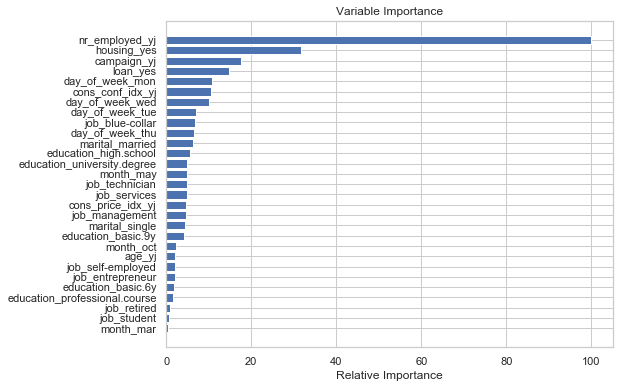

In [110]:
feature_importance = clf_gbc_cv_best.feature_importances_

plt.figure(figsize=(8,6))
# IMPORTANCES RELATIVE TO MAX IMPORTANCE
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Gradient Boost Classifier had different order of feature importances than that of Extra Trees Classifier even though both tree based. 

In Gradient Boost Classifier the continuous variables perform well, and may be favored by the trees inside the ensemble model. With regard to economic, which are reported monthly and quarterly, some skepticism may be warranted. These may be specific conditions to a period in time, but provide some input into if marketing is more successful when economy growing, shrinking, flat, and the like.

Campaign basically speaks to the fewer the calls, the better the conversion. Success decreases when by exceed 4.

Age is rather low in feature importances. Age conversion rate had an inverse correlation with count by age group. Meaning high conversion for young and old, but low for majority between 25 - 55.

For categorical variables, housing, loan, day of week, marital and job appear to have the strongest importances.

### Marketing strategy recommendations:  

Key to successful marketing strategy will be to determine wether a mass market or high probability for conversion approach is preferred. 

Estimates for the cost of acquistion and the lifetime value of the subscription when a yes is received would be helpful.  

Once the cost benefit is available, can create a threshold for decision making and cater the campaign to meet either the budget or mass market requirements.    

If not mass market then would consider these to optimize cost benefit: 
* Know cost of acquisition and lifetime value
* Concentrate on > 40 and keep contacts < 4
* Determine favorable economic environment
* Categorical variables, focus on home loan, personal loan, day of week, and job. 

#### Weaknesses
* GBC performance dropped in test. 
* Precision and recall dropped in test for "1" class. The low performance may speak to inability to generalize and market to target audience effectively.
* Economic data is primarily monthly or quarterly and likely specific to time period and not reliable. 
* Not an even dispersion of telemarketing calls over months.
* Jobs vary by region, may not be helpful and introduce bias.
* Some of categorical variables have a higher conversion rate at tails of distribution, but low rates for the majority. Significance, if not controlled for, may not scale in real world.   

#### Proposal for Additional Studies:

1) Model sensitivity:  
To check sensitivity of models to training set, one can set the SMOTE split to different training/testing percentages. For example, to test small training set, set to .05, then go to .5, then to .9 to see which model is performs best and which is most consistent across the split sizes. 

2) PCA and other dimension reduction techniques:  
Interesting study would be two take the top two PCA components and graph to see if have linear seperation, polynomial, or blob. Before the predictions graph and use 'y', the target variable, as the color. For SVM use RBF if blob, polynomial if polynomial.

3) Variation on SMOTE:  
Test undersampling the majority verses oversampling the majority, and alternative methods to balance the training set.

4) Cluster Analysis:
Do customer segmentation for yes and no target labels and idenify attributes of high probability customer, and low probability customer.
  
5) No economic or social inputs.

6) Quantify lifetime value of customer.

7) Quantify cost of acquisition.